In [1]:
#Código completo para la reducción de los datos de ciencia
#creado 25 de Agosto de 2017 (versión 1)
# Paso 1 (generar una lista de archivos separando Bias, SkyFlats y Ciencia)
import numpy as np
import glob
import scipy as sp
import astropy.io.fits as pf
import matplotlib.pyplot as plt
% matplotlib inline

b1=[]          #Creando una lista (Bias)
f1=[]          #Creandço una lista (Flats)
w1=[]          #Creando una lista (Ciencia)

all_files_fits=glob.glob("*.fits") #Leyendo todos archivos *.fits

for files1 in all_files_fits: 
    data10=pf.open(files1)               #Abriendo los archivos listados en all_files
    object=data10[0].header["object"]   #En esta línea buscamos en el header la palabra claves 
    if "Bias" in object:
        b1.append(files1)
    if "Sky" in object:
        f1.append(files1)
    if "wasp" in object:
        w1.append(files1)

texto=open("flats2.txt","w")        #Creando un archivo de texto para guardar los datos Flats

for name in f1:
    texto.write(name+"\n")         
texto.close()

texto=open("Bias2.txt","w")         #Creando un archivo de texto para guardar los datos Bias

for name in b1:
    texto.write(name+"\n")
texto.close()

texto=open("science2.txt","w")      #Creando un archivo de texto para guardar los datos Ciencia

for name in w1:
    texto.write(name+"\n")
texto.close()

KeyError: "Keyword 'OBJECT' not found."

In [2]:
#Código completo para la reducción de los datos de ciencia
#creado 25 de Agosto de 2017 (versión 1)
# Paso 1 (generar una lista de archivos separando Bias, SkyFlats y Ciencia)
import numpy as np
import glob
import scipy as sp
import astropy.io.fits as pf
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
# Paso 2 (Generar el archivo Master Bias)
Bias=np.array(['Bias_000001.fits'])
cubo_Bias=[]                                      #Generando un array para guardar los datos de ma media de los Bias 
for k in range(len(Bias)):            #creando los datos para el archivo cubo_Bias
    archivo=pf.open(Bias[k])
    data=archivo[0].data                     #se filtra el archivo con [0] porque los datos estan contenidos allí
    cubo_Bias.append(data)
Master_Bias=sp.median(cubo_Bias,axis=0) #Línea para calcular la media de los Bias conbinados. El filtro [0] interpreta 
                                         #que debe calcular la media de cada archivo por cada pixel en ellos.

In [4]:
def zscale(Bias,  trim = 0.05, contr=1, mask=None):
    """Returns lower and upper limits found by zscale algorithm for improved contrast in astronomical images.

:param mask: bool ndarray
    True are good pixels, pixels marked as False are ignored
:rtype: (min, max)
    Minimum and maximum values recommended by zscale
"""

    if not isinstance(Bias, sp.ndarray):
        Bias = sp.array(Bias)
    if mask is None:
        mask = (sp.isnan(Bias)==False)

    itrim = int(Bias.size*trim)
    x = sp.arange(mask.sum()-2*itrim)+itrim

    sy = sp.sort(Bias[mask].flatten())[itrim:Bias[mask].size-itrim]
    t,b = sp.polyfit(x, sy, 1)

    return b,t*Bias.size/contr+b

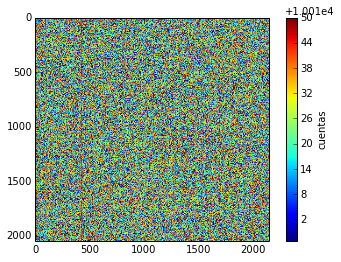

IOError: File 'Master_Bias_final.fits' already exists.

In [5]:
#para graficar el master bias
minv,maxv=zscale(Master_Bias)
plt.imshow(Master_Bias,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Master_Bias.png')
plt.show()
pf.writeto("Master_Bias_final.fits", Master_Bias, header=None, output_verify='exception', clobber=False, checksum=False)

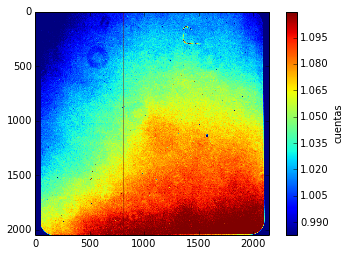

In [6]:
#paso 3 (Generar el archivo Master Flats)
    #se debe restar en cada imagen flats el archivo Master_Bias
flats=np.array(['SkyFlatI_000001.fits'])


#=np.loadtxt('flats.txt',dtype=str)
#creando una función que calcule el Master_Flats
def master(flats,mb):
    cubo_Flats=[]
    for k in range(len(flats)):
        archivo_flats=pf.open(flats[k])
        data_flats=archivo_flats[0].data
        resta=data_flats-mb
        cubo_Flats.append(resta)
    return cubo_Flats
cubo_Flats=master(flats,Master_Bias)
#normalizar cada flats
cubo_Flats_norm=[]
for imagen in cubo_Flats:
    #Flats_median=np.median(imagen)
    Flats_median=np.average(imagen)
    new_im=imagen/Flats_median
    cubo_Flats_norm.append(new_im)
#saca la mediana combinada luego de normalizar
Master_Flats=sp.median(cubo_Flats_norm,axis=0)
O_Master_Flats=np.array(Master_Flats)

#para graficar el master flats normalizado
minv,maxv=zscale(Master_Flats)
plt.imshow(Master_Flats,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Master_Flats_final.png')
plt.show()
#línea para combertir el array en un archivo .fits
#pf.writeto("Master_Flats.fits",Master_Flats, header=None, output_verify='exception', clobber=False, checksum=False)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


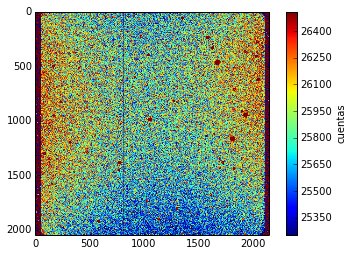

In [50]:
#paso 4 generar los archivos ciencia a detallar 
DATA_science=np.loadtxt('science.txt',dtype=str)#leyendo el archivo .txt donde esta la lista de archivos .fits para Bias
#DATA_science=np.array(['wasp43_000001.fits','wasp43_000002.fits'])
cubo_science=[]                                  #Generando un array para guardar los datos de ma media de los Bias 
for k in range(len(DATA_science)):               #creando los datos para el archivo cubo_Bias
    archivo_science=pf.open(DATA_science[k])
    data_science=archivo_science[0].data        #se filtra el archivo con [0] porque los datos est an contenidos allí
    DATA_FINAL=(data_science-Master_Bias)/Master_Flats
    cubo_science.append(DATA_FINAL)
    
minv,maxv=zscale(cubo_science[1])
plt.imshow(cubo_science[1],vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('Science.png')
plt.show()


In [62]:
#esto es para sacar la estampilla
def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]

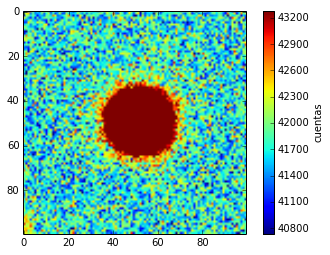

In [73]:
#tener encuenta que python lee primero la coordenada 'y' y luego la 'x' 
science1=stamp(cubo_science[0],992,1051,50)
minv,maxv=zscale(science1)
plt.imshow(science1,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('stampilla.png')

In [64]:
diana=stamp(cubo_science[1],1055,1007,50)

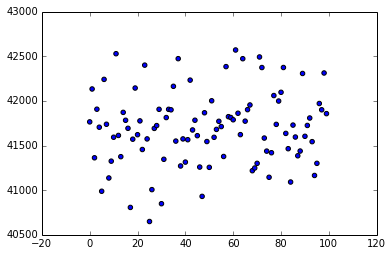

In [74]:
xxx=np.arange(0,100,1)
plt.scatter(xxx,science1[80])


In [75]:
from scipy import optimize

def gaussian(height, center_x, center_y, width_x):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_x)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

<function matplotlib.pyplot.axes>

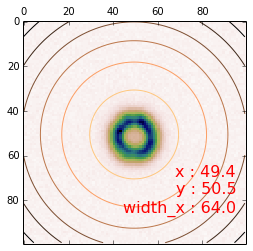

In [79]:
plt.matshow(science1.T, cmap=plt.cm.gist_earth_r)

params = fitgaussian(science1)
fit = gaussian(*params)

plt.contour(fit(*np.indices(science1.shape)).T, cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
""" %(x, y, width_x),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes,color='red')
plt.axes

In [80]:
x,y

(49.405707282425389, 50.51146668263064)

In [14]:
science[science<minv]=minv
science[science>maxv]=maxv

<function matplotlib.pyplot.axes>

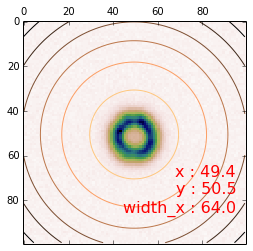

In [81]:
plt.matshow(science1.T, cmap=plt.cm.gist_earth_r)

params = fitgaussian(science1)
fit = gaussian(*params)

plt.contour(fit(*np.indices(science1.shape)).T, cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
""" %(x, y, width_x),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes,color='red')
plt.axes

(59.154640485828558, 52.41583663703215)


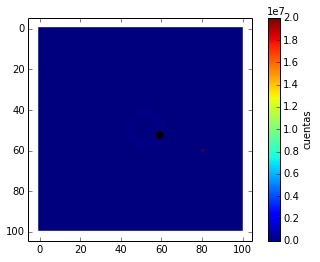

In [82]:
scif=(science1-science1.min())
scif[60,80]=20000000
plt.imshow(scif)
yc,xc=ndimage.measurements.center_of_mass(scif) #recordar que la primer coordenada es 'y' y luego es 'x'
plt.colorbar(label='cuentas')
plt.scatter(xc,yc,s=50,c='k')
print(xc,yc)

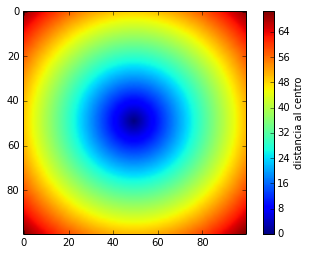

In [83]:
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc,xc=ndimage.measurements.center_of_mass(science) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science),0:len(science)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total=np.sqrt((AX-int(xc))**2+(AY-int(yc))**2)

plt.plot
plt.imshow(distancia_total)
plt.colorbar(label='distancia al centro')
plt.savefig('distancia_centro.png')

In [86]:
ndimage.measurements.center_of_mass(science) #recordar que la primer coordenada es 'y' y luego es 'x'



(49.642841094224003, 49.582920026123837)

In [85]:
yc,xc=ndimage.measurements.center_of_mass(science1) #recordar que la primer coordenada es 'y' y luego es 'x'



In [87]:
np.argmax(science)

5466

In [88]:
science.shape

(100, 100)

<function matplotlib.pyplot.show>

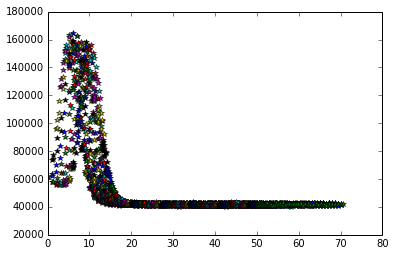

In [89]:
#dibujando el perfil radial 
plt.plot(distancia_total,science1,"*")
plt.savefig('perfil_radial.png')
plt.show

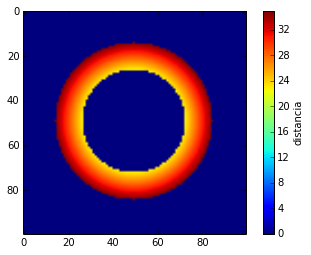

In [90]:
#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porcion de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo=distancia_total>=23 #extraigo la primera parte del anillo
radio_interior_anillo.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo=distancia_total<=35
radio_exterior_anillo.astype(np.int)                     #combirtiendo de boolean a int
cielo=distancia_total*radio_interior_anillo*radio_exterior_anillo #cielo 

#grafica de cielo en 2D 
plt.plot
plt.imshow(cielo)
plt.colorbar(label='distancia')
plt.savefig('mascara_anillo.png')


<function matplotlib.pyplot.show>

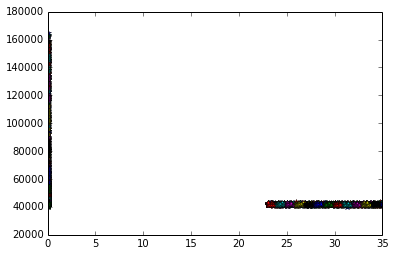

In [91]:
#perfil radial del campo
plt.plot(cielo,science1,"*")
plt.show
#consultar a Germán por qué se ven valores en la coordenada (0, :)?

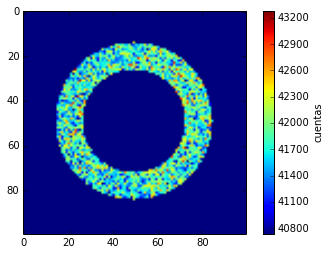

In [93]:
#grafica del campo aplicando mascara anillo
campo_anillo=science1*radio_interior_anillo*radio_exterior_anillo 
minv,maxv=zscale(science1)
plt.imshow(campo_anillo,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('campo_anillo.png')

In [94]:
mediana_cielo=np.median(campo_anillo[radio_exterior_anillo])

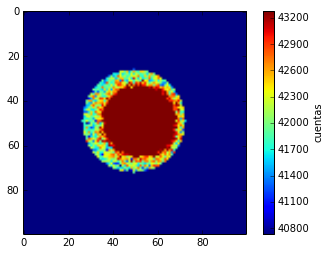

In [96]:
#generando la apertura de la estrella
apertura=distancia_total<=23
apertura.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella=science1*apertura-mediana_cielo
apertura_estrella.astype(np.int)
apertura_estrella1=science1*apertura
apertura_estrella1.astype(np.int)
apertura_distancia=distancia_total<=23
apertura_distancia.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia=apertura_distancia*distancia_total
minv,maxv=zscale(science1)
plt.imshow(apertura_estrella1,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('apertura_extrella.png')

<function matplotlib.pyplot.show>

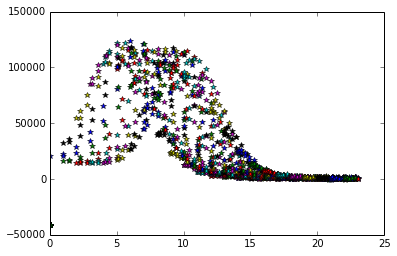

In [97]:
plt.plot(apertura_distancia,apertura_estrella,"*")
plt.show

In [98]:
#apertura valores menores a cero
apertura_estrella[apertura_estrella <0]=0
#a[a < 2] = 0

<function matplotlib.pyplot.show>

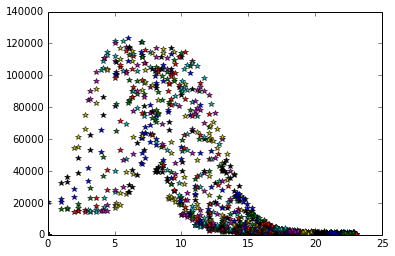

In [99]:
plt.plot(apertura_distancia,apertura_estrella,"*")
plt.show

In [100]:
apertura_estrella.sum(axis=0)   # suma columna (primera dimensión)
flujo=np.array(apertura_estrella.sum(axis=0)) #lo combierto en una lista
flujo_total=np.sum(flujo)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total

32687984.827858828

In [101]:
#generando la 2º estampilla, se toma otea estrella del campo 
def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]

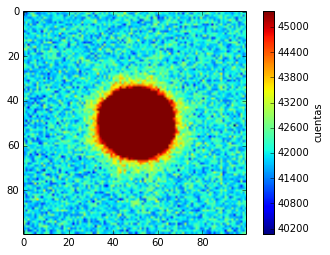

In [102]:
#tener encuenta que python lee primero la coordenada 'y' y luego la 'x' 
science_second=stamp(cubo_science[0],1166,1806,50)
minv,maxv=zscale(science_second)
plt.imshow(science_second,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('second_stamp.png')

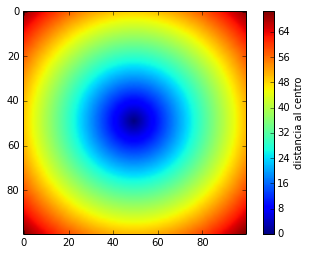

In [103]:
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc_second,xc_second=ndimage.measurements.center_of_mass(science_second) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science_second),0:len(science_second)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total_second=np.sqrt((AX-int(xc_second))**2+(AY-int(yc_second))**2)

plt.plot
plt.imshow(distancia_total_second)
plt.colorbar(label='distancia al centro')
plt.savefig('distancia_centro_second.png')

<function matplotlib.pyplot.show>

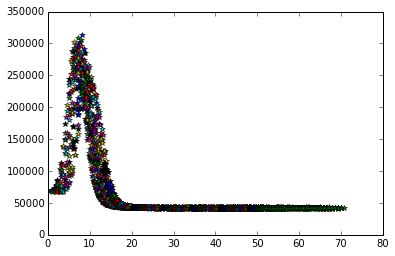

In [104]:
#dibujando el perfil radial 
plt.plot(distancia_total_second,science_second,"*")
plt.savefig('perfil_radial.png')
plt.show

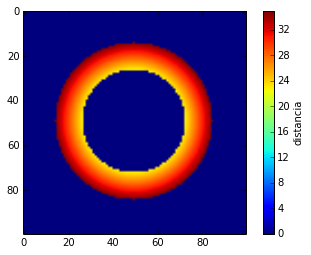

In [105]:
#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porción de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo_second=distancia_total_second>=23 #extraigo la primera parte del anillo
radio_interior_anillo_second.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo_second=distancia_total_second<=35
radio_exterior_anillo_second.astype(np.int)                     #combirtiendo de boolean a int
cielo_second=distancia_total_second*radio_interior_anillo_second*radio_exterior_anillo_second #cielo 

#grafica de cielo en 2D 
plt.plot
plt.imshow(cielo_second)
plt.colorbar(label='distancia')
plt.savefig('mascara_anillo_second.png')


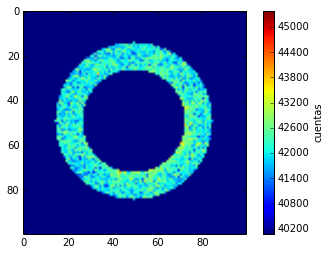

In [106]:
#grafica del campo aplicando mascara anillo
campo_anillo_second=science_second*radio_interior_anillo_second*radio_exterior_anillo_second 
minv,maxv=zscale(science_second)
plt.imshow(campo_anillo_second,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('campo_anillo_second.png')

In [107]:
mediana_cielo_second=np.median(campo_anillo_second[radio_exterior_anillo_second])

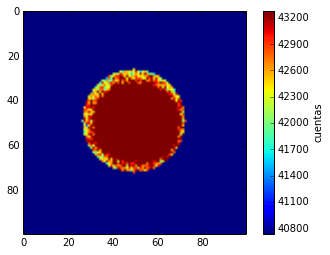

In [132]:
#generando la apertura de la estrella
apertura_second=distancia_total_second<=23
apertura_second.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella_second=science_second*apertura_second-mediana_cielo_second
apertura_estrella_second.astype(np.int)
apertura_estrella_second1=science_second*apertura_second
apertura_estrella_second1.astype(np.int)
apertura_distancia_second=distancia_total_second<=23
apertura_distancia_second.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia_second=apertura_distancia_second*distancia_total_second
minv,maxv=zscale(science1)
plt.imshow(apertura_estrella_second1,vmin=minv,vmax=maxv)
plt.colorbar(label='cuentas')
plt.savefig('apertura_extrella_second.png')

<function matplotlib.pyplot.show>

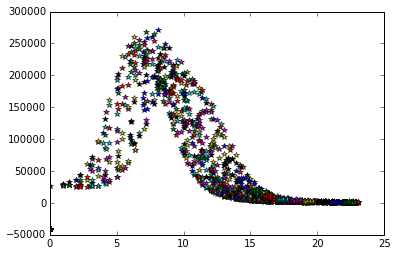

In [133]:
plt.plot(apertura_distancia_second,apertura_estrella_second,"*")
plt.show

In [134]:
#apertura valores menores a cero
apertura_estrella_second[apertura_estrella_second <0]=0
#a[a < 2] = 0

<function matplotlib.pyplot.show>

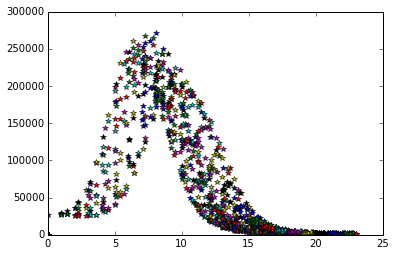

In [135]:
plt.plot(apertura_distancia_second,apertura_estrella_second,"*")
plt.show

In [199]:
apertura_estrella_second.sum(axis=0)   # suma columna (primera dimensión)
flujo_second=np.array(apertura_estrella_second.sum(axis=0)) #lo combierto en una lista
flujo_total_second=np.sum(flujo_second)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total_second

72269007.601681724

52875246.298503503

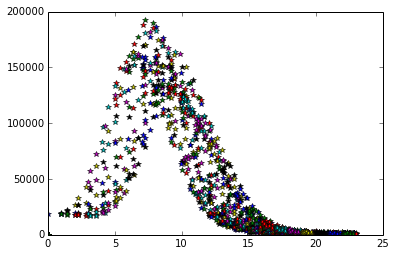

In [200]:
#generando la 3º estampilla, se toma otra estrella del campo 
def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]
science_third=stamp(cubo_science[0],470,1667,50)
minv,maxv=zscale(science_third)
#plt.imshow(science_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('second_stamp_third.png')
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc_third,xc_third=ndimage.measurements.center_of_mass(science_third) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science_third),0:len(science_third)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total_third=np.sqrt((AX-int(xc_third))**2+(AY-int(yc_third))**2)

#plt.plot
#plt.imshow(distancia_total_third)
#plt.colorbar(label='distancia al centro')
#plt.savefig('distancia_centro_third.png')

#dibujando el perfil radial 
#plt.plot(distancia_total_third,science_third,"*")
#plt.savefig('perfil_radial_third.png')
#plt.show

#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porción de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo_third=distancia_total_third>=23 #extraigo la primera parte del anillo
radio_interior_anillo_third.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo_third=distancia_total_third<=35
radio_exterior_anillo_third.astype(np.int)                     #combirtiendo de boolean a int
cielo_third=distancia_total_third*radio_interior_anillo_third*radio_exterior_anillo_third #cielo 

#grafica de cielo en 2D 
#plt.plot
#plt.imshow(cielo_third)
#plt.colorbar(label='distancia')
#plt.savefig('mascara_anillo_third.png')

#grafica del campo aplicando mascara anillo
campo_anillo_third=science_third*radio_interior_anillo_third*radio_exterior_anillo_third 
minv,maxv=zscale(science_third)
#plt.imshow(campo_anillo_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('campo_anillo_third.png')
mediana_cielo_third=np.median(campo_anillo_third[radio_exterior_anillo_third])

#generando la apertura de la estrella
apertura_third=distancia_total_third<=23
apertura_third.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella_third=science_third*apertura_third-mediana_cielo_third
apertura_estrella_third.astype(np.int)
apertura_estrella_third1=science_third*apertura_third
apertura_estrella_third1.astype(np.int)
apertura_distancia_third=distancia_total_third<=23
apertura_distancia_third.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia_third=apertura_distancia_third*distancia_total_third
minv,maxv=zscale(science1)
#plt.imshow(apertura_estrella_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('apertura_extrella_third.png')

#plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
#plt.show

#apertura valores menores a cero
apertura_estrella_third[apertura_estrella_third <0]=0
#a[a < 2] = 0

plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
plt.show

apertura_estrella_third.sum(axis=0)   # suma columna (primera dimensión)
flujo_third=np.array(apertura_estrella_third.sum(axis=0)) #lo combierto en una lista
flujo_total_third=np.sum(flujo_third)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total_third

In [145]:
mediana_cielo_third

41628.721352491659

In [201]:
dia1A=flujo_total/flujo_total_second
dia1B=flujo_total/flujo_total_third


In [202]:
dia1A,dia1B

(0.4523098616217634, 0.61820959931460362)

32512962.368054174

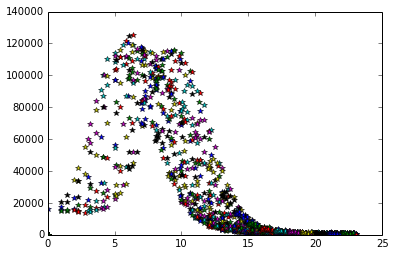

In [151]:
#generando el mismo proceso anterior pero para la siguiente imagen ciencia 

#estampilla 1º

def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]
science_first=stamp(cubo_science[1],992,1051,50)
minv,maxv=zscale(science_first)
#plt.imshow(science_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('second_stamp_third.png')
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc_first,xc_first=ndimage.measurements.center_of_mass(science_first) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science_first),0:len(science_first)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total_first=np.sqrt((AX-int(xc_first))**2+(AY-int(yc_first))**2)

#plt.plot
#plt.imshow(distancia_total_third)
#plt.colorbar(label='distancia al centro')
#plt.savefig('distancia_centro_third.png')

#dibujando el perfil radial 
#plt.plot(distancia_total_third,science_third,"*")
#plt.savefig('perfil_radial_third.png')
#plt.show

#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porción de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo_first=distancia_total_first>=23 #extraigo la primera parte del anillo
radio_interior_anillo_first.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo_first=distancia_total_first<=35
radio_exterior_anillo_first.astype(np.int)                     #combirtiendo de boolean a int
cielo_first=distancia_total_first*radio_interior_anillo_first*radio_exterior_anillo_first #cielo 

#grafica de cielo en 2D 
#plt.plot
#plt.imshow(cielo_third)
#plt.colorbar(label='distancia')
#plt.savefig('mascara_anillo_third.png')

#grafica del campo aplicando mascara anillo
campo_anillo_first=science_first*radio_interior_anillo_first*radio_exterior_anillo_first 
minv,maxv=zscale(science_first)
#plt.imshow(campo_anillo_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('campo_anillo_third.png')
mediana_cielo_first=np.median(campo_anillo_first[radio_exterior_anillo_first])

#generando la apertura de la estrella
apertura_first=distancia_total_first<=23
apertura_first.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella_first=science_first*apertura_first-mediana_cielo_first
apertura_estrella_first.astype(np.int)
apertura_estrella_first1=science_first*apertura_first
apertura_estrella_first1.astype(np.int)
apertura_distancia_first=distancia_total_first<=23
apertura_distancia_first.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia_first=apertura_distancia_first*distancia_total_first
minv,maxv=zscale(science1)
#plt.imshow(apertura_estrella_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('apertura_extrella_third.png')

#plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
#plt.show

#apertura valores menores a cero
apertura_estrella_first[apertura_estrella_first <0]=0
#a[a < 2] = 0

plt.plot(apertura_distancia_first,apertura_estrella_first,"*")
plt.show

apertura_estrella_first.sum(axis=0)   # suma columna (primera dimensión)
flujo_first=np.array(apertura_estrella_first.sum(axis=0)) #lo combierto en una lista
flujo_total_first_2=np.sum(flujo_first)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total_first_2

72269007.601681724

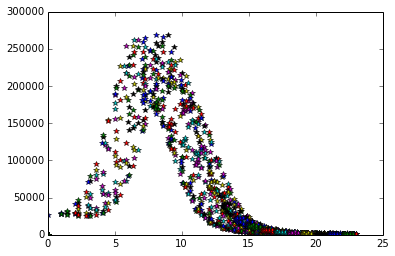

In [152]:
#generando el mismo proceso anterior pero para la siguiente imagen ciencia 

#estampilla 2º

def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]
science_second=stamp(cubo_science[1],1166,1806,50)
minv,maxv=zscale(science_second)
#plt.imshow(science_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('second_stamp_third.png')
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc_second,xc_second=ndimage.measurements.center_of_mass(science_second) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science_second),0:len(science_second)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total_third=np.sqrt((AX-int(xc_second))**2+(AY-int(yc_second))**2)

#plt.plot
#plt.imshow(distancia_total_third)
#plt.colorbar(label='distancia al centro')
#plt.savefig('distancia_centro_third.png')

#dibujando el perfil radial 
#plt.plot(distancia_total_third,science_third,"*")
#plt.savefig('perfil_radial_third.png')
#plt.show

#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porción de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo_second=distancia_total_second>=23 #extraigo la primera parte del anillo
radio_interior_anillo_second.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo_second=distancia_total_second<=35
radio_exterior_anillo_second.astype(np.int)                     #combirtiendo de boolean a int
cielo_second=distancia_total_second*radio_interior_anillo_second*radio_exterior_anillo_second #cielo 

#grafica de cielo en 2D 
#plt.plot
#plt.imshow(cielo_third)
#plt.colorbar(label='distancia')
#plt.savefig('mascara_anillo_third.png')

#grafica del campo aplicando mascara anillo
campo_anillo_second=science_second*radio_interior_anillo_second*radio_exterior_anillo_second 
minv,maxv=zscale(science_second)
#plt.imshow(campo_anillo_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('campo_anillo_third.png')
mediana_cielo_second=np.median(campo_anillo_second[radio_exterior_anillo_second])

#generando la apertura de la estrella
apertura_second=distancia_total_second<=23
apertura_second.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella_second=science_second*apertura_second-mediana_cielo_second
apertura_estrella_second.astype(np.int)
apertura_estrella_second1=science_second*apertura_second
apertura_estrella_second1.astype(np.int)
apertura_distancia_second=distancia_total_second<=23
apertura_distancia_second.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia_second=apertura_distancia_second*distancia_total_second
minv,maxv=zscale(science1)
#plt.imshow(apertura_estrella_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('apertura_extrella_third.png')

#plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
#plt.show

#apertura valores menores a cero
apertura_estrella_second[apertura_estrella_second <0]=0
#a[a < 2] = 0

plt.plot(apertura_distancia_second,apertura_estrella_second,"*")
plt.show

apertura_estrella_second.sum(axis=0)   # suma columna (primera dimensión)
flujo_second=np.array(apertura_estrella_second.sum(axis=0)) #lo combierto en una lista
flujo_total_second_2=np.sum(flujo_second)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total_second_2

52822940.224793062

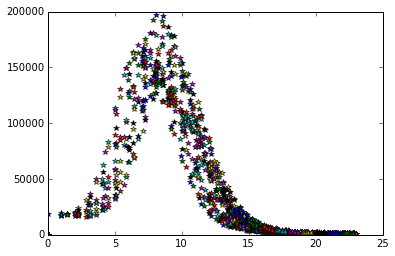

In [153]:
#generando el mismo proceso anterior pero para la siguiente imagen ciencia 

#estampilla 3º

def stamp(imagen,y,x,radio):
    return imagen[y-radio:y+radio,x-radio:x+radio]
science_third=stamp(cubo_science[1],470,1667,50)
minv,maxv=zscale(science_third)
#plt.imshow(science_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('second_stamp_third.png')
#líneas para calcular el centro de "masas"
from scipy import ndimage
yc_third,xc_third=ndimage.measurements.center_of_mass(science_third) #recordar que la primer coordenada es 'y' y luego es 'x'
AY,AX=np.mgrid[0:len(science_third),0:len(science_third)] # genera dos arreglos (0,1,2,3,...,n) del tamaño de la estampilla

#calculando la distancia a todos los puntos respecto del centro de la estampilla
distancia_total_third=np.sqrt((AX-int(xc_third))**2+(AY-int(yc_third))**2)

#plt.plot
#plt.imshow(distancia_total_third)
#plt.colorbar(label='distancia al centro')
#plt.savefig('distancia_centro_third.png')

#dibujando el perfil radial 
#plt.plot(distancia_total_third,science_third,"*")
#plt.savefig('perfil_radial_third.png')
#plt.show

#calculando el promedio de las cuentas para cielo, es decir, debemos extraer del perfil radial, una porción de
# que represente el valor en cuentas del 'cielo' para luego promediarlo y extraerlo del valor de cuentas de la estrella

radio_interior_anillo_third=distancia_total_third>=23 #extraigo la primera parte del anillo
radio_interior_anillo_third.astype(np.int)                     #combirtiendo de boolean a int
radio_exterior_anillo_third=distancia_total_third<=35
radio_exterior_anillo_third.astype(np.int)                     #combirtiendo de boolean a int
cielo_third=distancia_total_third*radio_interior_anillo_third*radio_exterior_anillo_third #cielo 

#grafica de cielo en 2D 
#plt.plot
#plt.imshow(cielo_third)
#plt.colorbar(label='distancia')
#plt.savefig('mascara_anillo_third.png')

#grafica del campo aplicando mascara anillo
campo_anillo_third=science_third*radio_interior_anillo_third*radio_exterior_anillo_third 
minv,maxv=zscale(science_third)
#plt.imshow(campo_anillo_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('campo_anillo_third.png')
mediana_cielo_third=np.median(campo_anillo_third[radio_exterior_anillo_third])

#generando la apertura de la estrella
apertura_third=distancia_total_third<=23
apertura_third.astype(np.int)                     #combirtiendo de boolean a int
apertura_estrella_third=science_third*apertura_third-mediana_cielo_third
apertura_estrella_third.astype(np.int)
apertura_estrella_third1=science_third*apertura_third
apertura_estrella_third1.astype(np.int)
apertura_distancia_third=distancia_total_third<=23
apertura_distancia_third.astype(np.int)                     #combirtiendo de boolean a int
apertura_distancia_third=apertura_distancia_third*distancia_total_third
minv,maxv=zscale(science1)
#plt.imshow(apertura_estrella_third,vmin=minv,vmax=maxv)
#plt.colorbar(label='cuentas')
#plt.savefig('apertura_extrella_third.png')

#plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
#plt.show

#apertura valores menores a cero
apertura_estrella_third[apertura_estrella_third <0]=0
#a[a < 2] = 0

plt.plot(apertura_distancia_third,apertura_estrella_third,"*")
plt.show

apertura_estrella_third.sum(axis=0)   # suma columna (primera dimensión)
flujo_third=np.array(apertura_estrella_third.sum(axis=0)) #lo combierto en una lista
flujo_total_third_2=np.sum(flujo_third)    #sumo la lista para tener el flujo total de la estrella en cuentas
flujo_total_third_2

In [156]:
dia2A=flujo_total_first/flujo_total_second_2
dia2B=flujo_total/flujo_total_third_2


In [204]:
dia1A=flujo_total/flujo_total_second
dia1B=flujo_total/flujo_total_third

In [205]:
are=[dia2A,dia2B,dia1A,dia1B]

In [206]:
 x_prueba = np.linspace(0,2,4)

In [207]:
GRAF=np.loadtxt('datos.txt',dtype=str)

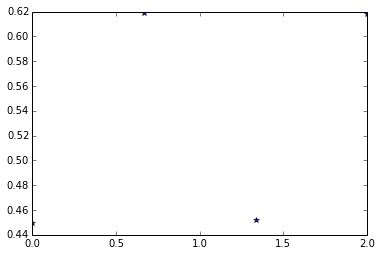

In [208]:
plt.plot(x_prueba,are,'*')

In [209]:
are

[0.44988804256525566,
 0.61882175980269161,
 0.4523098616217634,
 0.61820959931460362]